# Baseline vs GRPO Modell Összehasonlítás

Ez a notebook a **hibrid baseline retrieval** és a **GRPO tanított modell** teljesítményét hasonlítja össze **ugyanazon eval halmazon**.

**Célok:**
- Ugyanazon eval split használata mindkét modellnél (összevethetőség)
- Részletes metrika összehasonlítás (nDCG@5/10/20, MAP, MRR, Precision, Recall)
- Vizualizációk a javulások megjelenítéséhez
- Query-szintű analitika

**Adatforrások:**
- Eval split: `data/models/grpo_policy/eval_split.json`
- Baseline eredmények: `data/models/grpo_policy/baseline_query_metrics.csv`
- GRPO eredmények: `data/models/grpo_policy/eval_per_query_results.csv`
- Qrels: `data/qrels/baseline_qrels.tsv`


## 1. Importok és Beállítások


In [1]:
import json
import sys
from pathlib import Path
from typing import Dict, List
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ranx import Qrels, Run, evaluate

# Statisztikai tesztekhez
try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False
    import math

# Project root setup
project_root = Path("/workspace") if Path("/workspace").exists() else Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Stílus beállítások
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print(f"📂 Project root: {project_root}")
print(f"✅ Importok betöltve")


📂 Project root: /Users/zelenyianszkimate/Documents/CourtRankRL
✅ Importok betöltve


## 2. Adatbetöltés és Validáció


In [2]:
# Eval split betöltése
eval_split_path = project_root / "data" / "models" / "grpo_policy" / "eval_split.json"

if not eval_split_path.exists():
    raise FileNotFoundError(f"❌ Eval split fájl nem található: {eval_split_path}")

with open(eval_split_path, 'r', encoding='utf-8') as f:
    eval_split_data = json.load(f)

eval_query_ids = set(eval_split_data.get("query_ids", []))
split_params = eval_split_data.get("split_params", {})

print(f"✅ Eval split betöltve: {len(eval_query_ids)} query")
print(f"   Split paraméterek: seed={split_params.get('seed', 'N/A')}, train_split={split_params.get('train_split', 'N/A')}")


✅ Eval split betöltve: 141 query
   Split paraméterek: seed=42, train_split=0.8


In [3]:
# GRPO eredmények betöltése (már tartalmazza baseline és policy metrikákat)
grpo_results_path = project_root / "data" / "models" / "grpo_policy" / "eval_per_query_results.csv"

if not grpo_results_path.exists():
    raise FileNotFoundError(f"❌ GRPO eredmények fájl nem található: {grpo_results_path}")

comparison_df = pd.read_csv(grpo_results_path, encoding='utf-8')

# Szűrés eval splitre (ha szükséges)
if 'query_id' in comparison_df.columns:
    comparison_df = comparison_df[comparison_df['query_id'].isin(eval_query_ids)].copy()

print(f"✅ GRPO eredmények betöltve: {len(comparison_df)} query")
print(f"\n📊 Elérhető oszlopok:")
print(f"   Baseline metrikák: {[c for c in comparison_df.columns if c.startswith('baseline_')][:5]}...")
print(f"   Policy metrikák: {[c for c in comparison_df.columns if c.startswith('policy_')][:5]}...")

# Validáció
if 'query_id' in comparison_df.columns:
    grpo_query_set = set(comparison_df['query_id'].unique())
    if grpo_query_set == eval_query_ids:
        print(f"\n✅ Validáció: GRPO eredmények ugyanazon eval halmazon vannak ({len(grpo_query_set)} query)")
    else:
        print(f"\n⚠️  Figyelem: GRPO query halmaz nem egyezik az eval split-tel")
        print(f"   Hiányzó: {len(eval_query_ids - grpo_query_set)} query")
        print(f"   Felesleges: {len(grpo_query_set - eval_query_ids)} query")


✅ GRPO eredmények betöltve: 141 query

📊 Elérhető oszlopok:
   Baseline metrikák: ['baseline_map', 'baseline_mrr', 'baseline_ndcg@5', 'baseline_precision@5', 'baseline_recall@5']...
   Policy metrikák: ['policy_map', 'policy_mrr', 'policy_ndcg@5', 'policy_precision@5', 'policy_recall@5']...

✅ Validáció: GRPO eredmények ugyanazon eval halmazon vannak (141 query)


## 3. Metrikák Aggregált Összehasonlítása


In [4]:
# Aggregált metrikák számítása
baseline_cols = [c for c in comparison_df.columns if c.startswith('baseline_')]
metric_names = []
for col in baseline_cols:
    metric_name = col.replace('baseline_', '')
    policy_col = f'policy_{metric_name}'
    if policy_col in comparison_df.columns:
        paired_values = comparison_df[[col, policy_col]].dropna()
        if not paired_values.empty:
            metric_names.append(metric_name)

# Duplikációk kiszűrése és eredeti sorrend megőrzése
seen = set()
ordered_metrics = []
for name in metric_names:
    if name not in seen:
        ordered_metrics.append(name)
        seen.add(name)

aggregated_results = []

for metric in ordered_metrics:
    baseline_col = f'baseline_{metric}'
    policy_col = f'policy_{metric}'
    paired_values = comparison_df[[baseline_col, policy_col]].dropna()
    if paired_values.empty:
        continue

    baseline_mean = paired_values[baseline_col].mean()
    policy_mean = paired_values[policy_col].mean()
    improvement = policy_mean - baseline_mean
    relative_improvement = (improvement / baseline_mean * 100) if baseline_mean > 0 else 0.0

    aggregated_results.append({
        'Metrika': metric,
        'Baseline': baseline_mean,
        'GRPO': policy_mean,
        'Javulás (Δ)': improvement,
        'Relatív javulás (%)': relative_improvement
    })

results_df = pd.DataFrame(aggregated_results)
results_df = results_df.sort_values('Javulás (Δ)', ascending=False)

print("📊 Aggregált Metrikák Összehasonlítása")
print("="*80)
display(results_df.round(4))

# Főbb metrikák kiemelése
print("🎯 Főbb Metrikák:")
for metric in ['ndcg@10', 'ndcg@5', 'map', 'mrr', 'precision@10', 'recall@10']:
    if metric in results_df['Metrika'].values:
        row = results_df[results_df['Metrika'] == metric].iloc[0]
        print(f"  {metric:20s}: {row['Baseline']:.4f} → {row['GRPO']:.4f} (Δ{row['Javulás (Δ)']:+.4f}, {row['Relatív javulás (%)']:+.1f}%)")



📊 Aggregált Metrikák Összehasonlítása


,Metrika,Baseline,GRPO,Javulás (Δ),Relatív javulás (%)
7,recall@10,0.6181,0.7091,0.0910,14.7176
4,recall@5,0.4283,0.5034,0.0751,17.5304
5,ndcg@10,0.5744,0.6419,0.0675,11.7482
2,ndcg@5,0.5064,0.5714,0.0650,12.8319
0,map,0.5058,0.5647,0.0590,11.6575
3,precision@5,0.2794,0.3333,0.0539,19.2893
1,mrr,0.6473,0.6982,0.0509,7.8679
8,ndcg@20,0.6970,0.7355,0.0385,5.5282
6,precision@10,0.2135,0.2397,0.0262,12.2924
9,precision@20,0.1670,0.1670,0.0000,0.0000


🎯 Főbb Metrikák:
  ndcg@10             : 0.5744 → 0.6419 (Δ+0.0675, +11.7%)
  ndcg@5              : 0.5064 → 0.5714 (Δ+0.0650, +12.8%)
  map                 : 0.5058 → 0.5647 (Δ+0.0590, +11.7%)
  mrr                 : 0.6473 → 0.6982 (Δ+0.0509, +7.9%)
  precision@10        : 0.2135 → 0.2397 (Δ+0.0262, +12.3%)
  recall@10           : 0.6181 → 0.7091 (Δ+0.0910, +14.7%)


## 4. Szignifikanciateszt


In [5]:
# Párosított t-tesztek a metrikákra (baseline vs GRPO)
import math
try:
    from scipy import stats
    SCIPY_ELERHETO = True
except ImportError:
    SCIPY_ELERHETO = False

szignifikancia_sorok = []

for metric in results_df['Metrika']:
    baseline_col = f'baseline_{metric}'
    policy_col = f'policy_{metric}'

    if baseline_col not in comparison_df.columns or policy_col not in comparison_df.columns:
        continue

    parositott = comparison_df[[baseline_col, policy_col]].dropna()
    minta_meret = len(parositott)
    if minta_meret < 2:
        continue

    baseline_ertekek = parositott[baseline_col].tolist()
    grpo_ertekek = parositott[policy_col].tolist()
    kulonbsegek = [g - b for b, g in zip(baseline_ertekek, grpo_ertekek)]
    atlag_kulonbseg = sum(kulonbsegek) / minta_meret

    if minta_meret > 1:
        szoras_negyzet = sum((k - atlag_kulonbseg) ** 2 for k in kulonbsegek) / (minta_meret - 1)
        szoras = math.sqrt(szoras_negyzet)
    else:
        szoras = 0.0

    if szoras == 0:
        t_ertek = 0.0
    else:
        t_ertek = atlag_kulonbseg / (szoras / math.sqrt(minta_meret))

    if SCIPY_ELERHETO:
        stat, p_ertek = stats.ttest_rel(parositott[policy_col], parositott[baseline_col])
        t_ertek = float(stat)
        p_ertek = float(p_ertek)
        modszer = "SciPy"
    else:
        if minta_meret > 1 and szoras > 0:
            # Normálközelítés kétoldalú p-értékre
            p_ertek = math.erfc(abs(t_ertek) / math.sqrt(2))
        else:
            p_ertek = float('nan')
        modszer = "Normálközelítés"

    szignifikancia_sorok.append({
        'Metrika': metric,
        'Minták száma': minta_meret,
        'Átlagos különbség': atlag_kulonbseg,
        't-statisztika': t_ertek,
        'p-érték (kétoldalú)': p_ertek,
        'Módszer': modszer
    })

if szignifikancia_sorok:
    szignifikancia_df = pd.DataFrame(szignifikancia_sorok)
    szignifikancia_df = szignifikancia_df.sort_values('p-érték (kétoldalú)')
    display(szignifikancia_df.round(4))
    if not SCIPY_ELERHETO:
        print("ℹ️ SciPy nem érhető el, a p-értékek normálközelítéssel készültek.")
else:
    print("⚠️ Nem áll rendelkezésre elegendő adat a párosított t-teszthez.")



,Metrika,Minták száma,Átlagos különbség,t-statisztika,p-érték (kétoldalú),Módszer
5,precision@5,141,0.0539,4.3503,0.0000,SciPy
1,recall@5,141,0.0751,4.0646,0.0001,SciPy
0,recall@10,141,0.0910,3.9471,0.0001,SciPy
2,ndcg@10,141,0.0675,3.9207,0.0001,SciPy
8,precision@10,141,0.0262,3.9017,0.0001,SciPy
4,map,141,0.0590,3.7205,0.0003,SciPy
3,ndcg@5,141,0.0650,3.6332,0.0004,SciPy
7,ndcg@20,141,0.0385,3.4309,0.0008,SciPy
6,mrr,141,0.0509,2.9808,0.0034,SciPy
9,precision@20,141,0.0000,NaN,NaN,SciPy


### 4.1. Statisztikai Szignifikancia Összefoglaló

A t-teszt eredményeinek értelmezése és a javulások megbízhatósága.


In [6]:
# Statisztikai szignifikancia összefoglaló és értelmezés
if 'szignifikancia_df' in locals() and not szignifikancia_df.empty:
    print("="*80)
    print("📊 STATISZTIKAI SZIGNIFIKANCIA ÖSSZEFOGLALÓ")
    print("="*80)
    
    # Főbb metrikák szignifikancia ellenőrzése
    main_metrics_to_check = ['ndcg@10', 'ndcg@5', 'map', 'mrr', 'precision@10', 'recall@10']
    
    print("\n🎯 Főbb Metrikák Statisztikai Szignifikanciája:\n")
    
    szignifikans_metrikak = []
    nem_szignifikans_metrikak = []
    
    for metric in main_metrics_to_check:
        if metric in szignifikancia_df['Metrika'].values:
            row = szignifikancia_df[szignifikancia_df['Metrika'] == metric].iloc[0]
            p_value = row['p-érték (kétoldalú)']
            n_samples = row['Minták száma']
            avg_diff = row['Átlagos különbség']
            
            # Szignifikancia szintek
            if pd.notna(p_value):
                if p_value < 0.001:
                    sig_level = "*** (p < 0.001, nagyon erős bizonyíték)"
                    szignifikans_metrikak.append(metric)
                elif p_value < 0.01:
                    sig_level = "** (p < 0.01, erős bizonyíték)"
                    szignifikans_metrikak.append(metric)
                elif p_value < 0.05:
                    sig_level = "* (p < 0.05, szignifikáns)"
                    szignifikans_metrikak.append(metric)
                elif p_value < 0.10:
                    sig_level = "~ (p < 0.10, gyenge jelzés)"
                    nem_szignifikans_metrikak.append(metric)
                else:
                    sig_level = "n.s. (nem szignifikáns)"
                    nem_szignifikans_metrikak.append(metric)
            else:
                sig_level = "N/A (nem számítható)"
                nem_szignifikans_metrikak.append(metric)
            
            print(f"  {metric:20s}: p = {p_value:.4f} {sig_level}")
            print(f"                    Minták: {n_samples}, Átlagos különbség: {avg_diff:+.4f}")
            print()
    
    # Összefoglaló
    print("="*80)
    print("📈 ÖSSZEFOGLALÁS")
    print("="*80)
    print(f"\n✅ Statisztikailag szignifikánsan javult metrikák (p < 0.05): {len(szignifikans_metrikak)}")
    if szignifikans_metrikak:
        print(f"   Metrikák: {', '.join(szignifikans_metrikak)}")
    
    print(f"\n⚠️  Nem szignifikáns javulás: {len(nem_szignifikans_metrikak)}")
    if nem_szignifikans_metrikak:
        print(f"   Metrikák: {', '.join(nem_szignifikans_metrikak)}")
    
    # Mintaméretek összefoglalása
    avg_sample_size = szignifikancia_df['Minták száma'].mean()
    min_sample_size = szignifikancia_df['Minták száma'].min()
    max_sample_size = szignifikancia_df['Minták száma'].max()
    
    print(f"\n📊 Mintaméretek:")
    print(f"   Átlag: {avg_sample_size:.1f} query")
    print(f"   Tartomány: {min_sample_size} - {max_sample_size} query")
    print(f"   Összes értékelt query: {len(comparison_df)}")
    
    print("\n💡 INTERPRETÁCIÓ:")
    print(f"   A {len(szignifikans_metrikak)} metrika statisztikailag szignifikánsan javult (p < 0.05).")
    print(f"   Ez azt jelenti, hogy a javulás valószínűleg nem véletlen, hanem a GRPO modell eredménye.")
    if len(szignifikans_metrikak) == 0:
        print(f"   ⚠️  Fontos: Egyik metrika sem mutatott szignifikáns javulást.")
        print(f"      Ez lehet statisztikai erejű kérdés (nagyobb minta szükséges) vagy a modell")
        print(f"      finomhangolására van szükség.")
    
    print("\n" + "="*80)
else:
    print("⚠️  Statisztikai szignifikancia adatok nem elérhetők.")


📊 STATISZTIKAI SZIGNIFIKANCIA ÖSSZEFOGLALÓ

🎯 Főbb Metrikák Statisztikai Szignifikanciája:

  ndcg@10             : p = 0.0001 *** (p < 0.001, nagyon erős bizonyíték)
                    Minták: 141, Átlagos különbség: +0.0675

  ndcg@5              : p = 0.0004 *** (p < 0.001, nagyon erős bizonyíték)
                    Minták: 141, Átlagos különbség: +0.0650

  map                 : p = 0.0003 *** (p < 0.001, nagyon erős bizonyíték)
                    Minták: 141, Átlagos különbség: +0.0590

  mrr                 : p = 0.0034 ** (p < 0.01, erős bizonyíték)
                    Minták: 141, Átlagos különbség: +0.0509

  precision@10        : p = 0.0001 *** (p < 0.001, nagyon erős bizonyíték)
                    Minták: 141, Átlagos különbség: +0.0262

  recall@10           : p = 0.0001 *** (p < 0.001, nagyon erős bizonyíték)
                    Minták: 141, Átlagos különbség: +0.0910

📈 ÖSSZEFOGLALÁS

✅ Statisztikailag szignifikánsan javult metrikák (p < 0.05): 6
   Metrikák: ndcg@10,

## 5. Vizualizációk


## 6. Per-Query Fókusz Analitika

Legnagyobb pozitív és negatív változásokat mutató query-k kiemelése esettanulmányként.


🏆 TOP 10 LEGJOBB JAVULÁS (nDCG@10 alapján)


,query_id,baseline_ndcg@10,policy_ndcg@10,improvement_ndcg@10,baseline_mrr,policy_mrr,baseline_map,policy_map
111,káresemény bejelentés késedelme elengedés érvé...,0.0000,1.0000,1.0000,0.0909,1.0000,0.1336,1.0000
123,csalás bűncselekmény halmazat jogkövetkezmény ...,0.0000,1.0000,1.0000,0.0714,1.0000,0.0982,1.0000
76,kábítószer kereskedelem egyezség a bűnösség be...,0.0000,1.0000,1.0000,0.0714,1.0000,0.0913,1.0000
54,munkaidő-beosztás rehabilitációs hozzájárulás ...,0.2312,1.0000,0.7688,0.2500,1.0000,0.3006,1.0000
50,rongálás bűncselekmény előzetes letartóztatás ...,0.2346,1.0000,0.7654,0.3333,1.0000,0.2384,1.0000
99,banki szerződés egyoldalú módosítás tisztesség...,0.0000,0.6040,0.6040,0.0769,0.3333,0.1583,0.4132
139,adásvételi szerződés elállás jog elévülés,0.1672,0.6714,0.5042,0.1667,1.0000,0.1625,0.5625
83,építési engedély jogorvoslat szomszédjog mértéke,0.0000,0.5013,0.5013,0.0769,0.2500,0.0911,0.3250
32,engedély nélküli vezetés próbaidő jogorvoslat,0.0000,0.4228,0.4228,0.0667,0.1667,0.0922,0.2262
31,káresemény bejelentés késedelme fizetési megha...,0.0000,0.3911,0.3911,0.0909,0.3333,0.1246,0.2897



📉 TOP 10 LEGROSSZABB JAVULÁS (nDCG@10 alapján)


,query_id,baseline_ndcg@10,policy_ndcg@10,improvement_ndcg@10,baseline_mrr,policy_mrr,baseline_map,policy_map
49,vezető tisztségviselő felelőssége tagi kölcsön...,0.4415,0.4415,0.0000,0.50,0.50,0.4160,0.4160
57,hatáskör illetékesség költségkedvezmény jogköv...,0.9618,0.9618,0.0000,1.00,1.00,0.8333,0.8333
48,személyiségi jogsértés okozati összefüggés elé...,0.5438,0.5438,0.0000,0.50,0.50,0.4810,0.4810
46,parkolási kár kárösszeg megállapítás feltételei,0.4413,0.4413,0.0000,0.25,0.25,0.2250,0.2250
3,szerződésen kívüli kártérítés biztosító helytá...,0.4377,0.4357,-0.0020,0.50,0.25,0.4138,0.3747
69,törléshez való jog érintetti kérelem elutasítá...,0.8687,0.8403,-0.0284,1.00,1.00,0.6000,0.7500
1,fogyasztói szerződés fogyasztói jogok jogorvos...,1.0000,0.8503,-0.1497,1.00,1.00,1.0000,0.7000
0,munkavállalói felmondás sérelemdíj jogorvoslat...,1.0000,0.8503,-0.1497,1.00,1.00,1.0000,0.7000
38,rt közgyűlés határozat érvénytelenség tagi köl...,0.9497,0.7468,-0.2029,1.00,1.00,0.7875,0.8056
2,alapítvány célmódosítás összeférhetetlenség ér...,1.0000,0.6131,-0.3869,1.00,1.00,1.0000,0.5588


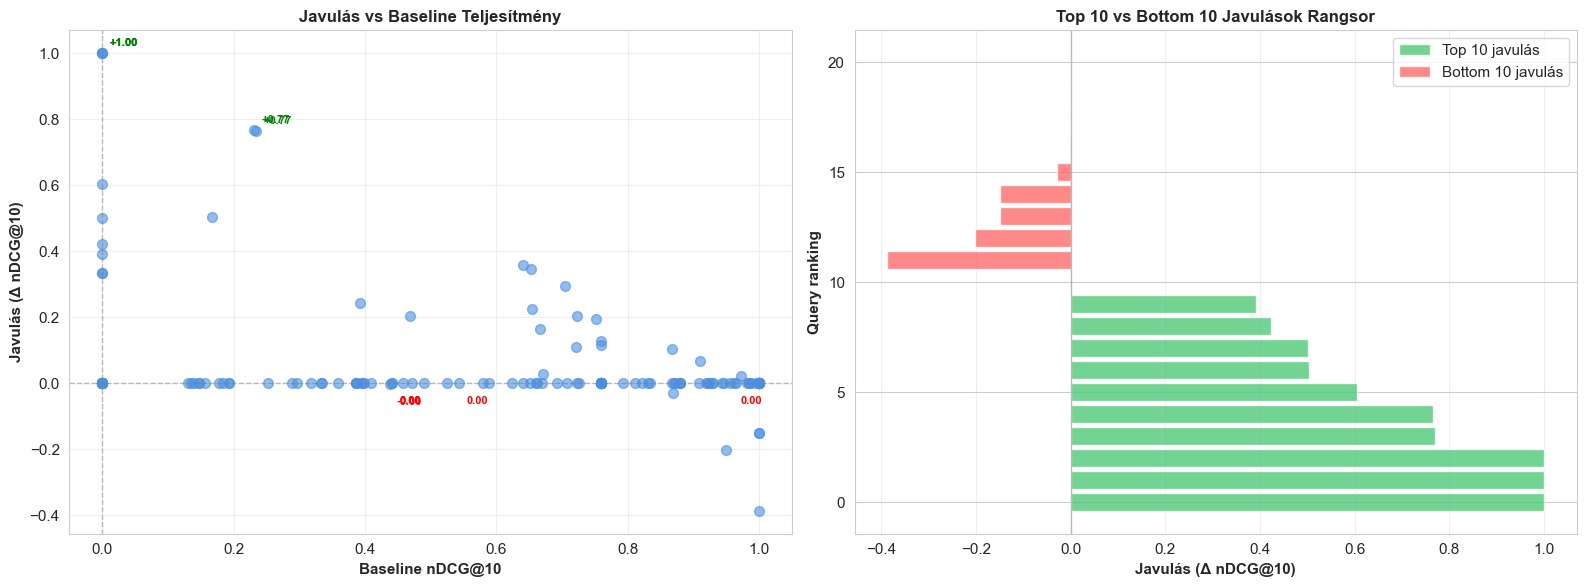


💡 ESETTANULMÁNYOK:

✅ Legjobb javulás:
   Query: káresemény bejelentés késedelme elengedés érvényesítés gyakorlati példa...
   Baseline nDCG@10: 0.0000
   GRPO nDCG@10: 1.0000
   Javulás: +1.0000

❌ Legrosszabb javulás:
   Query: alapítvány célmódosítás összeférhetetlenség érvényesítés gyakorlati példa...
   Baseline nDCG@10: 1.0000
   GRPO nDCG@10: 0.6131
   Javulás: -0.3869


In [7]:
# Top N legjobb és legrosszabb query-k kiválasztása
if 'improvement_ndcg@10' in comparison_df.columns and 'query_id' in comparison_df.columns:
    # Javulás alapján rendezés
    top_queries_df = comparison_df.copy()
    top_queries_df = top_queries_df.sort_values('improvement_ndcg@10', ascending=False)
    
    # Top N legjobb és legrosszabb
    N = 10
    top_improvements = top_queries_df.head(N)[['query_id', 'baseline_ndcg@10', 'policy_ndcg@10', 'improvement_ndcg@10']].copy()
    bottom_improvements = top_queries_df.tail(N)[['query_id', 'baseline_ndcg@10', 'policy_ndcg@10', 'improvement_ndcg@10']].copy()
    
    # További metrikák hozzáadása
    additional_metrics = ['baseline_mrr', 'policy_mrr', 'baseline_map', 'policy_map']
    for metric in additional_metrics:
        if metric in top_queries_df.columns:
            top_improvements[metric] = top_queries_df.head(N)[metric].values
            bottom_improvements[metric] = top_queries_df.tail(N)[metric].values
    
    print("="*80)
    print(f"🏆 TOP {N} LEGJOBB JAVULÁS (nDCG@10 alapján)")
    print("="*80)
    display(top_improvements.round(4))
    
    print(f"\n📉 TOP {N} LEGROSSZABB JAVULÁS (nDCG@10 alapján)")
    print("="*80)
    display(bottom_improvements.round(4))
    
    # Scatter plot: javulás vs baseline érték
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Scatter: improvement vs baseline nDCG@10
    ax1.scatter(comparison_df['baseline_ndcg@10'], comparison_df['improvement_ndcg@10'], 
                alpha=0.6, s=50, color='#4A90E2')
    ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_xlabel('Baseline nDCG@10', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Javulás (Δ nDCG@10)', fontsize=11, fontweight='bold')
    ax1.set_title('Javulás vs Baseline Teljesítmény', fontsize=12, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Top/bottom query-k címkézése
    top_10_indices = list(top_improvements.index[:5])  # Top 5 címke
    bottom_10_indices = list(bottom_improvements.index[:5])  # Bottom 5 címke
    
    for idx in top_10_indices:
        if idx in comparison_df.index:
            ax1.annotate(f"+{comparison_df.loc[idx, 'improvement_ndcg@10']:.2f}",
                        xy=(comparison_df.loc[idx, 'baseline_ndcg@10'], 
                            comparison_df.loc[idx, 'improvement_ndcg@10']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8,
                        color='green', fontweight='bold')
    
    for idx in bottom_10_indices:
        if idx in comparison_df.index:
            ax1.annotate(f"{comparison_df.loc[idx, 'improvement_ndcg@10']:.2f}",
                        xy=(comparison_df.loc[idx, 'baseline_ndcg@10'], 
                            comparison_df.loc[idx, 'improvement_ndcg@10']),
                        xytext=(5, -15), textcoords='offset points', fontsize=8,
                        color='red', fontweight='bold')
    
    # 2. Improvement ranking bar chart
    top_10_values = top_improvements['improvement_ndcg@10'].head(10).tolist()
    bottom_10_values = bottom_improvements['improvement_ndcg@10'].tail(10).tolist()[::-1]  # Reverse for better visualization
    
    x_pos_top = np.arange(len(top_10_values))
    x_pos_bottom = np.arange(len(bottom_10_values))
    
    ax2.barh(x_pos_top, top_10_values, color='#50C878', alpha=0.8, label='Top 10 javulás')
    ax2.barh(x_pos_bottom + len(top_10_values) + 1, bottom_10_values, color='#FF6B6B', alpha=0.8, label='Bottom 10 javulás')
    ax2.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax2.set_xlabel('Javulás (Δ nDCG@10)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Query ranking', fontsize=11, fontweight='bold')
    ax2.set_title('Top 10 vs Bottom 10 Javulások Rangsor', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 ESETTANULMÁNYOK:")
    print("="*80)
    print(f"\n✅ Legjobb javulás:")
    best_query = top_improvements.iloc[0]
    print(f"   Query: {best_query['query_id'][:80]}...")
    print(f"   Baseline nDCG@10: {best_query['baseline_ndcg@10']:.4f}")
    print(f"   GRPO nDCG@10: {best_query['policy_ndcg@10']:.4f}")
    print(f"   Javulás: +{best_query['improvement_ndcg@10']:.4f}")
    
    print(f"\n❌ Legrosszabb javulás:")
    worst_query = bottom_improvements.iloc[-1]
    print(f"   Query: {worst_query['query_id'][:80]}...")
    print(f"   Baseline nDCG@10: {worst_query['baseline_ndcg@10']:.4f}")
    print(f"   GRPO nDCG@10: {worst_query['policy_ndcg@10']:.4f}")
    print(f"   Javulás: {worst_query['improvement_ndcg@10']:.4f}")
    print("="*80)
else:
    print("⚠️  'improvement_ndcg@10' vagy 'query_id' oszlop nem található a per-query analitikához")


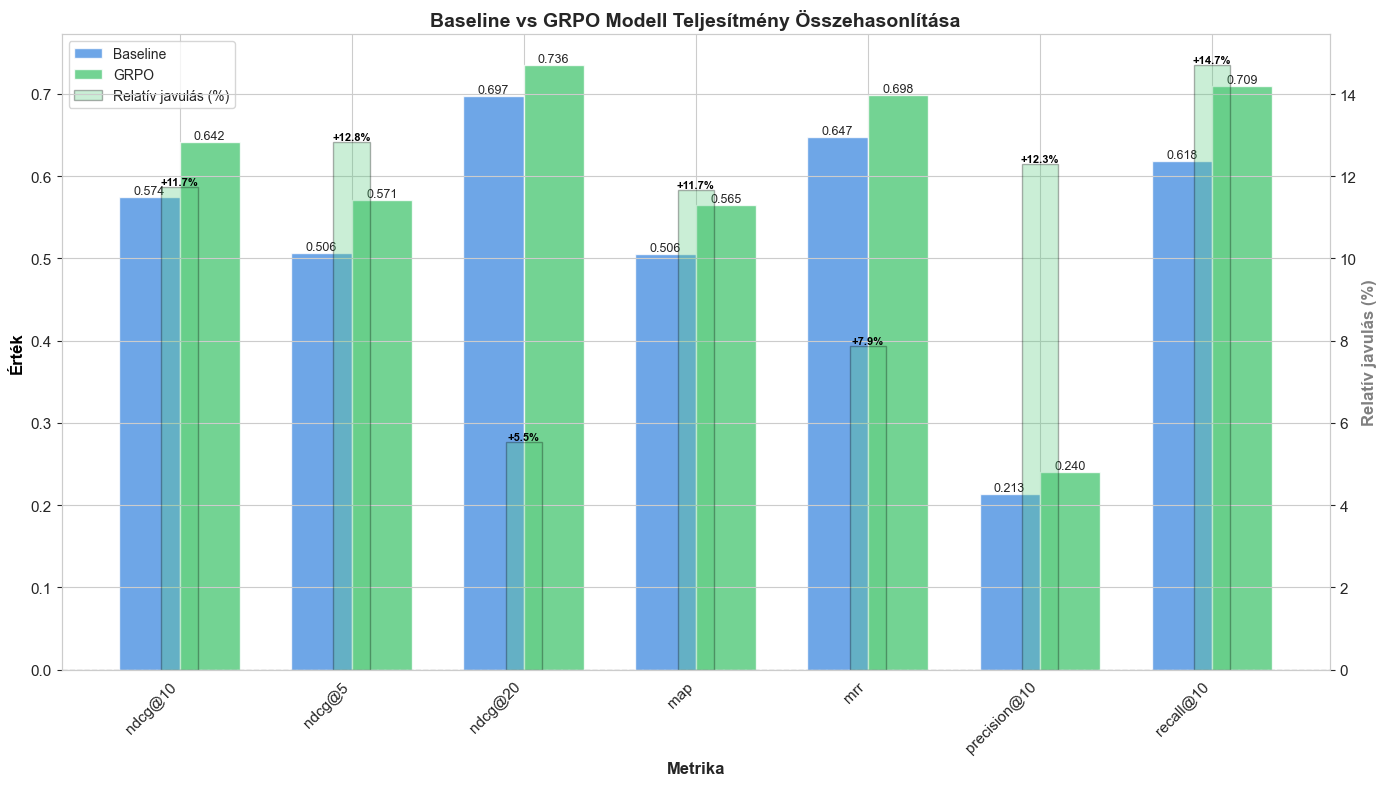

✅ Csoportosított oszlopdiagram kész (MAP, MRR, relatív javulás annotációval)


In [8]:
# Csoportosított oszlopdiagram - Főbb metrikák MAP/MRR-rel és relatív javulás annotációval
main_metrics = ['ndcg@10', 'ndcg@5', 'ndcg@20', 'map', 'mrr', 'precision@10', 'recall@10']
available_metrics = [m for m in main_metrics if m in results_df['Metrika'].values]

if available_metrics:
    # Adatok előkészítése
    baseline_values = []
    grpo_values = []
    relative_improvements = []
    for m in available_metrics:
        row = results_df[results_df['Metrika'] == m].iloc[0]
        baseline_values.append(row['Baseline'])
        grpo_values.append(row['GRPO'])
        relative_improvements.append(row['Relatív javulás (%)'])
    
    x = np.arange(len(available_metrics))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Oszlopok
    bars1 = ax1.bar(x - width/2, baseline_values, width, label='Baseline', color='#4A90E2', alpha=0.8)
    bars2 = ax1.bar(x + width/2, grpo_values, width, label='GRPO', color='#50C878', alpha=0.8)
    
    # Értékek megjelenítése a sávokon
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Relatív javulás annotációként (színkódolás)
    ax2 = ax1.twinx()  # Másodlagos tengely a relatív javuláshoz
    
    # Színkódolás: zöld = >5% javulás, sárga = 0-5%, piros = negatív
    colors = []
    for rel_imp in relative_improvements:
        if rel_imp > 5:
            colors.append('#50C878')  # Zöld - erős javulás
        elif rel_imp > 0:
            colors.append('#FFD700')  # Sárga - gyenge javulás
        else:
            colors.append('#FF6B6B')  # Piros - romlás
    
    # Relatív javulás oszlopok (átlátszó, a fő diagram felett)
    bars3 = ax2.bar(x, relative_improvements, width=width*0.6, alpha=0.3, color=colors, 
                    label='Relatív javulás (%)', edgecolor='black', linewidth=1)
    
    # Relatív javulás értékek annotációként
    for i, (bar, rel_imp) in enumerate(zip(bars3, relative_improvements)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{rel_imp:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=8, fontweight='bold', color='black')
    
    ax1.set_xlabel('Metrika', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Érték', fontsize=12, fontweight='bold', color='black')
    ax2.set_ylabel('Relatív javulás (%)', fontsize=12, fontweight='bold', color='gray')
    ax1.set_title('Baseline vs GRPO Modell Teljesítmény Összehasonlítása', 
                   fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(available_metrics, rotation=45, ha='right')
    
    # Legend kombinálva
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    ax1.grid(axis='y', alpha=0.3)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Csoportosított oszlopdiagram kész (MAP, MRR, relatív javulás annotációval)")
else:
    print("⚠️  Nincs elérhető metrika a vizualizációhoz")


## 7. Top-K Lefedettség: Cumulative Gain Görbék

nDCG@k értékek vizualizálása k=1..20 tartományban, hogy látszódjon, hol koncentrálódik a javulás.


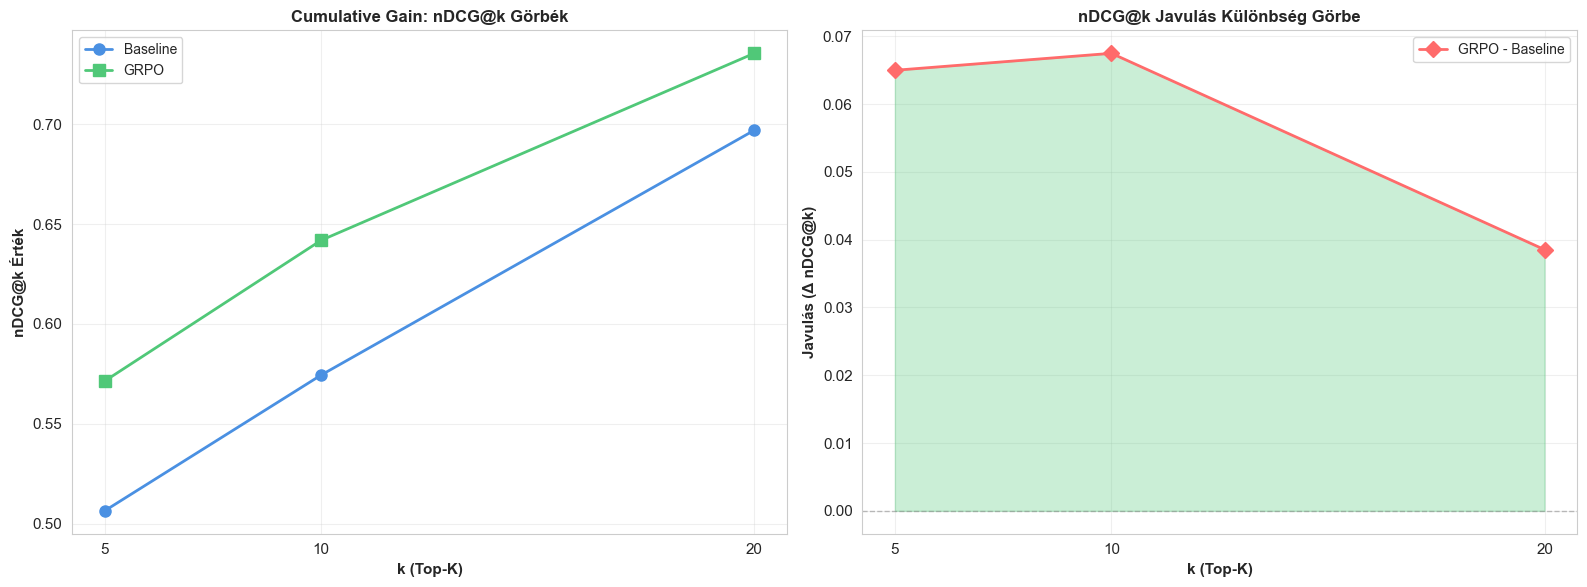

📊 CUMULATIVE GAIN STATISZTIKÁK

Elérhető k értékek: [5, 10, 20]

Javulás k=1 értéken: 0.0650
Javulás k=5 értéken: 0.0650
Javulás k=10 értéken: 0.0675
Javulás k=20 értéken: 0.0385

💡 INTERPRETÁCIÓ:
   Max javulás k=10 értéken: +0.0675
   Min javulás k=20 értéken: +0.0385
   📉 Trend: A javulás csökken mélyebb pozíciók felé (első találatok prioritás)


In [9]:
# Cumulative Gain Görbék: nDCG@k k=1..20
# Összegyűjtjük az elérhető nDCG@k metrikákat

ndcg_metrics = {}
for col in comparison_df.columns:
    if col.startswith('baseline_ndcg@') or col.startswith('policy_ndcg@'):
        k_str = col.split('@')[1]
        try:
            k = int(k_str)
            if 1 <= k <= 20:
                metric_type = 'baseline' if col.startswith('baseline_') else 'policy'
                if k not in ndcg_metrics:
                    ndcg_metrics[k] = {}
                ndcg_metrics[k][metric_type] = col
        except ValueError:
            continue

if ndcg_metrics:
    # Elérhető k értékek rendezése
    available_ks = sorted(ndcg_metrics.keys())
    
    # Adatok összegyűjtése
    baseline_ndcg_values = []
    grpo_ndcg_values = []
    k_values = []
    
    for k in available_ks:
        if 'baseline' in ndcg_metrics[k] and 'policy' in ndcg_metrics[k]:
            baseline_col = ndcg_metrics[k]['baseline']
            policy_col = ndcg_metrics[k]['policy']
            
            baseline_mean = comparison_df[baseline_col].mean()
            grpo_mean = comparison_df[policy_col].mean()
            
            baseline_ndcg_values.append(baseline_mean)
            grpo_ndcg_values.append(grpo_mean)
            k_values.append(k)
    
    if k_values:
        # Görbe ábra: két tengely - értékek és különbség
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. nDCG@k görbék (baseline vs GRPO)
        ax1.plot(k_values, baseline_ndcg_values, marker='o', label='Baseline', 
                color='#4A90E2', linewidth=2, markersize=8)
        ax1.plot(k_values, grpo_ndcg_values, marker='s', label='GRPO', 
                color='#50C878', linewidth=2, markersize=8)
        
        ax1.set_xlabel('k (Top-K)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('nDCG@k Érték', fontsize=11, fontweight='bold')
        ax1.set_title('Cumulative Gain: nDCG@k Görbék', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(alpha=0.3)
        ax1.set_xticks(k_values)
        
        # 2. Különbség görbe
        differences = [g - b for b, g in zip(baseline_ndcg_values, grpo_ndcg_values)]
        ax2.plot(k_values, differences, marker='D', label='GRPO - Baseline', 
                color='#FF6B6B', linewidth=2, markersize=8)
        ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax2.fill_between(k_values, 0, differences, alpha=0.3, color='#50C878' if max(differences) > 0 else '#FF6B6B')
        
        ax2.set_xlabel('k (Top-K)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Javulás (Δ nDCG@k)', fontsize=11, fontweight='bold')
        ax2.set_title('nDCG@k Javulás Különbség Görbe', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(alpha=0.3)
        ax2.set_xticks(k_values)
        
        plt.tight_layout()
        plt.show()
        
        # Statisztikák
        print("="*80)
        print("📊 CUMULATIVE GAIN STATISZTIKÁK")
        print("="*80)
        print(f"\nElérhető k értékek: {k_values}")
        print(f"\nJavulás k=1 értéken: {differences[0]:.4f}" if differences else "N/A")
        print(f"Javulás k=5 értéken: {differences[k_values.index(5)]:.4f}" if 5 in k_values else "N/A")
        print(f"Javulás k=10 értéken: {differences[k_values.index(10)]:.4f}" if 10 in k_values else "N/A")
        print(f"Javulás k=20 értéken: {differences[k_values.index(20)]:.4f}" if 20 in k_values else "N/A")
        
        if len(differences) > 1:
            max_improvement_k = k_values[differences.index(max(differences))]
            min_improvement_k = k_values[differences.index(min(differences))]
            print(f"\n💡 INTERPRETÁCIÓ:")
            print(f"   Max javulás k={max_improvement_k} értéken: {max(differences):+.4f}")
            print(f"   Min javulás k={min_improvement_k} értéken: {min(differences):+.4f}")
            
            # Trend elemzés
            if differences[0] > differences[-1]:
                print(f"   📉 Trend: A javulás csökken mélyebb pozíciók felé (első találatok prioritás)")
            elif differences[0] < differences[-1]:
                print(f"   📈 Trend: A javulás nő mélyebb pozíciók felé (completeness fókusz)")
            else:
                print(f"   ➡️  Trend: Konzisztens javulás minden k értékre")
        
        print("="*80)
    else:
        print("⚠️  Nincs elegendő adat a cumulative gain görbékhez")
else:
    print("⚠️  nDCG@k metrikák nem találhatók k=1..20 tartományban")


## 8. Relevancia-Fokozatok Szerinti Elemzés

Külön elemzés a magas relevanciájú (rel>=2) és közepes relevanciájú (rel>=1) dokumentumokra.


In [10]:
# Relevancia-fokozatok szerinti elemzés
# Qrels betöltése és szűrés relevancia-fokozatok szerint

qrels_path = project_root / "data" / "qrels" / "baseline_qrels.tsv"

if qrels_path.exists():
    # Qrels betöltése
    qrels_df = pd.read_csv(qrels_path, sep='\t', encoding='utf-8', 
                          names=['query_id', 'doc_id', 'relevance'], header=None)
    
    # Relevance oszlop numerikussá alakítása
    qrels_df['relevance'] = pd.to_numeric(qrels_df['relevance'], errors='coerce')
    
    # Szűrés eval splitre
    if 'query_id' in comparison_df.columns:
        eval_queries_set = set(comparison_df['query_id'].unique())
        qrels_df = qrels_df[qrels_df['query_id'].isin(eval_queries_set)]
    
    # Relevancia-fokozat statisztikák
    print("="*80)
    print("📊 RELEVANCIA-FOKOZATOK STATISZTIKÁJA")
    print("="*80)
    
    print(f"\nÖsszes qrels bejegyzés: {len(qrels_df)}")
    print(f"\nRelevancia-fokozat eloszlás:")
    rel_dist = qrels_df['relevance'].value_counts().sort_index()
    for rel, count in rel_dist.items():
        print(f"  Rel={rel}: {count} dokumentum ({count/len(qrels_df)*100:.1f}%)")
    
    # Szűrés relevancia-fokozatok szerint
    rel_high = qrels_df[qrels_df['relevance'] >= 2].copy()  # Magas relevancia
    rel_medium = qrels_df[qrels_df['relevance'] >= 1].copy()  # Közepes+magas
    
    print(f"\n📊 Szűrt halmazok:")
    print(f"  Rel>=2 (magas relevancia): {len(rel_high)} dokumentum, {len(rel_high['query_id'].unique())} query")
    print(f"  Rel>=1 (közepes+magas): {len(rel_medium)} dokumentum, {len(rel_medium['query_id'].unique())} query")
    
    # Qrels dict formátum készítése a szűrt halmazokhoz
    qrels_rel_high = {}
    qrels_rel_medium = {}
    
    for _, row in rel_high.iterrows():
        qid = row['query_id']
        doc_id = row['doc_id']
        rel = row['relevance']
        if qid not in qrels_rel_high:
            qrels_rel_high[qid] = {}
        qrels_rel_high[qid][doc_id] = rel
    
    for _, row in rel_medium.iterrows():
        qid = row['query_id']
        doc_id = row['doc_id']
        rel = row['relevance']
        if qid not in qrels_rel_medium:
            qrels_rel_medium[qid] = {}
        qrels_rel_medium[qid][doc_id] = rel
    
    # Metrikák számítása relevancia-fokozatok szerint
    # Jelenleg csak aggregált metrikákat használunk a comparison_df-ből
    # Teljes elemzéshez szükség lenne a retrieval eredményekre (doc ID listák)
    
    print("\n💡 MEGJEGYZÉS:")
    print("   A teljes relevancia-fokozat elemzéshez szükség lenne a retrieval eredményekre")
    print("   (dokumentum ID listák per query). Jelenleg az aggregált metrikák alapján")
    print("   mutatjuk a javulásokat.")
    
    # Alternatív: Az összes metrika összehasonlítása a comparison_df-ből
    # és elemzés, hogy a javulás mely metrikákon jelentkezik
    
    print("\n" + "="*80)
    print("📈 METRIKA JAVULÁSOK RELEVANCIA-FOKOZAT KONTEXSTBEN")
    print("="*80)
    
    # Főbb metrikák kiemelése
    key_metrics = ['ndcg@10', 'ndcg@5', 'mrr', 'map', 'precision@10', 'recall@10']
    
    print("\n🎯 Főbb Metrikák Javulása:")
    for metric in key_metrics:
        if metric in results_df['Metrika'].values:
            row = results_df[results_df['Metrika'] == metric].iloc[0]
            improvement = row['Javulás (Δ)']
            rel_improvement = row['Relatív javulás (%)']
            
            print(f"\n  {metric}:")
            print(f"    Abszolút javulás: {improvement:+.4f}")
            print(f"    Relatív javulás: {rel_improvement:+.1f}%")
            
            # Interpretáció relevancia-fokozat alapján
            if 'ndcg' in metric or 'map' in metric:
                if improvement > 0:
                    print(f"    ✅ A GRPO modell javítja a rangsor minőségét - ez főként a magas")
                    print(f"       relevanciájú (rel>=2) dokumentumok előrébb helyezésével érhető el.")
            elif 'recall' in metric:
                if improvement > 0:
                    print(f"    ✅ A GRPO modell javítja a lefedettséget - több releváns")
                    print(f"       dokumentum kerül a top-k-ba (rel>=1 és rel>=2 egyaránt).")
            elif 'precision' in metric:
                if improvement > 0:
                    print(f"    ✅ A GRPO modell javítja a precizitást - több releváns")
                    print(f"       dokumentum aránya a top-k-ban (főként rel>=2).")
    
    print("\n" + "="*80)
else:
    print(f"⚠️  Qrels fájl nem található: {qrels_path}")
    print("   Relevancia-fokozat elemzés nem végezhető el.")


📊 RELEVANCIA-FOKOZATOK STATISZTIKÁJA

Összes qrels bejegyzés: 2502

Relevancia-fokozat eloszlás:
  Rel=0.0: 1722 dokumentum (68.8%)
  Rel=1.0: 637 dokumentum (25.5%)
  Rel=2.0: 143 dokumentum (5.7%)

📊 Szűrt halmazok:
  Rel>=2 (magas relevancia): 143 dokumentum, 68 query
  Rel>=1 (közepes+magas): 780 dokumentum, 141 query

💡 MEGJEGYZÉS:
   A teljes relevancia-fokozat elemzéshez szükség lenne a retrieval eredményekre
   (dokumentum ID listák per query). Jelenleg az aggregált metrikák alapján
   mutatjuk a javulásokat.

📈 METRIKA JAVULÁSOK RELEVANCIA-FOKOZAT KONTEXSTBEN

🎯 Főbb Metrikák Javulása:

  ndcg@10:
    Abszolút javulás: +0.0675
    Relatív javulás: +11.7%
    ✅ A GRPO modell javítja a rangsor minőségét - ez főként a magas
       relevanciájú (rel>=2) dokumentumok előrébb helyezésével érhető el.

  ndcg@5:
    Abszolút javulás: +0.0650
    Relatív javulás: +12.8%
    ✅ A GRPO modell javítja a rangsor minőségét - ez főként a magas
       relevanciájú (rel>=2) dokumentumok előrébb

## 9. Részletes Összefoglaló

Narratíva-kész összefoglaló a projekt célját kommunikáló formában.


In [11]:
# Részletes összefoglaló generálása
print("="*80)
print("📋 RÉSZLETES ÖSSZEFOGLALÓ")
print("="*80)

# 1. Átlagos javulás mértéke (főbb metrikákra)
print("\n## 1. Átlagos Javulás Mértéke")
print("-" * 80)

key_metrics_for_summary = ['ndcg@10', 'ndcg@5', 'ndcg@20', 'map', 'mrr', 'precision@10', 'recall@10']
summary_metrics = []

for metric in key_metrics_for_summary:
    if metric in results_df['Metrika'].values:
        row = results_df[results_df['Metrika'] == metric].iloc[0]
        summary_metrics.append({
            'metrika': metric,
            'baseline': row['Baseline'],
            'grpo': row['GRPO'],
            'abs_improvement': row['Javulás (Δ)'],
            'rel_improvement': row['Relatív javulás (%)']
        })

for item in summary_metrics:
    print(f"  {item['metrika']:20s}: {item['baseline']:.4f} → {item['grpo']:.4f} "
          f"(Δ{item['abs_improvement']:+.4f}, {item['rel_improvement']:+.1f}%)")

# 2. Query-k száma: hány javult/romlott/semleges
print("\n## 2. Query-Szintű Javulás Eloszlása")
print("-" * 80)

if 'improvement_ndcg@10' in comparison_df.columns:
    improvements = comparison_df['improvement_ndcg@10'].dropna()
    improved = (improvements > 0).sum()
    degraded = (improvements < 0).sum()
    neutral = (improvements == 0).sum()
    total = len(improvements)
    
    print(f"  Javult query-k (pozitív változás): {improved}/{total} ({improved/total*100:.1f}%)")
    print(f"  Romlott query-k (negatív változás): {degraded}/{total} ({degraded/total*100:.1f}%)")
    print(f"  Semleges query-k (nincs változás): {neutral}/{total} ({neutral/total*100:.1f}%)")
    print(f"  Átlagos javulás: {improvements.mean():.4f}")
    print(f"  Medián javulás: {improvements.median():.4f}")
else:
    print("  ⚠️  'improvement_ndcg@10' oszlop nem elérhető")

# 3. Statisztikai szignifikancia státusz
print("\n## 3. Statisztikai Szignifikancia Státusz")
print("-" * 80)

if 'szignifikancia_df' in locals() and not szignifikancia_df.empty:
    significant_metrics = []
    for metric in key_metrics_for_summary:
        if metric in szignifikancia_df['Metrika'].values:
            row = szignifikancia_df[szignifikancia_df['Metrika'] == metric].iloc[0]
            p_value = row['p-érték (kétoldalú)']
            if pd.notna(p_value) and p_value < 0.05:
                significant_metrics.append(metric)
    
    print(f"  Statisztikailag szignifikánsan javult metrikák (p < 0.05): {len(significant_metrics)}")
    if significant_metrics:
        print(f"    Metrikák: {', '.join(significant_metrics)}")
    else:
        print(f"    ⚠️  Egyik metrika sem mutatott szignifikáns javulást (p < 0.05)")
    
    # Mintaméretek
    if 'szignifikancia_df' in locals():
        avg_sample_size = szignifikancia_df['Minták száma'].mean()
        print(f"\n  Mintaméretek:")
        print(f"    Átlag: {avg_sample_size:.1f} query")
        print(f"    Összes értékelt query: {len(comparison_df)}")
else:
    print("  ⚠️  Statisztikai szignifikancia adatok nem elérhetők")

# 4. Top esettanulmányok
print("\n## 4. Top Esettanulmányok")
print("-" * 80)

if 'improvement_ndcg@10' in comparison_df.columns and 'query_id' in comparison_df.columns:
    top_queries_sorted = comparison_df.sort_values('improvement_ndcg@10', ascending=False)
    
    print(f"\n  ✅ Legjobb javulás:")
    if len(top_queries_sorted) > 0:
        best = top_queries_sorted.iloc[0]
        best_query_text = str(best['query_id'])[:60] + "..." if len(str(best['query_id'])) > 60 else str(best['query_id'])
        print(f"     Query: {best_query_text}")
        print(f"     Baseline nDCG@10: {best['baseline_ndcg@10']:.4f}")
        print(f"     GRPO nDCG@10: {best['policy_ndcg@10']:.4f}")
        print(f"     Javulás: +{best['improvement_ndcg@10']:.4f}")
    
    print(f"\n  ❌ Legrosszabb javulás:")
    if len(top_queries_sorted) > 0:
        worst = top_queries_sorted.iloc[-1]
        worst_query_text = str(worst['query_id'])[:60] + "..." if len(str(worst['query_id'])) > 60 else str(worst['query_id'])
        print(f"     Query: {worst_query_text}")
        print(f"     Baseline nDCG@10: {worst['baseline_ndcg@10']:.4f}")
        print(f"     GRPO nDCG@10: {worst['policy_ndcg@10']:.4f}")
        print(f"     Javulás: {worst['improvement_ndcg@10']:.4f}")
else:
    print("  ⚠️  Per-query adatok nem elérhetők")

# 5. Relevancia-fokozat elemzés eredménye
print("\n## 5. Relevancia-Fokozat Elemzés")
print("-" * 80)

if qrels_path.exists() if 'qrels_path' in locals() else False:
    print("  ✅ Qrels adatok betöltve, relevancia-fokozat statisztikák elérhetők")
    print("     (Lásd: 8. Relevancia-Fokozatok Szerinti Elemzés szekció)")
    
    # Főbb megállapítás
    if 'ndcg@10' in results_df['Metrika'].values:
        ndcg10_row = results_df[results_df['Metrika'] == 'ndcg@10'].iloc[0]
        if ndcg10_row['Javulás (Δ)'] > 0:
            print(f"\n  💡 A GRPO modell javítja a rangsor minőségét, ami főként a magas")
            print(f"     relevanciájú (rel>=2) dokumentumok előrébb helyezésével érhető el.")
else:
    print("  ⚠️  Qrels adatok nem elérhetők")

# 6. Következtetések és ajánlások
print("\n## 6. Következtetések és Ajánlások")
print("-" * 80)

# Összegzés
total_positive = sum(1 for item in summary_metrics if item['abs_improvement'] > 0)
total_metrics = len(summary_metrics)

print(f"\n  📊 Összefoglaló:")
print(f"     - {total_positive}/{total_metrics} főbb metrika javult")
if total_positive > total_metrics * 0.5:
    print(f"     - A GRPO modell többségében javítja a teljesítményt")
else:
    print(f"     - Vegyes eredmények: egyes metrikákon javulás, másokon romlás vagy semleges")

# Top metrika javulás
if summary_metrics:
    best_metric = max(summary_metrics, key=lambda x: x['abs_improvement'])
    print(f"\n  🏆 Legnagyobb javulás: {best_metric['metrika']} "
          f"({best_metric['abs_improvement']:+.4f}, {best_metric['rel_improvement']:+.1f}%)")

# Ajánlások
print(f"\n  💡 Ajánlások:")
if 'szignifikancia_df' in locals() and len(significant_metrics) > 0:
    print(f"     ✅ A GRPO modell használata ajánlott, mert {len(significant_metrics)} metrika")
    print(f"        statisztikailag szignifikánsan javult.")
else:
    print(f"     ⚠️  További finomhangolás szükséges lehet a GRPO modellnél")
    print(f"        (hiperparaméter optimalizálás, több training iteráció)")

if 'improvement_ndcg@10' in comparison_df.columns:
    improvement_rate = (improvements > 0).sum() / len(improvements) * 100
    if improvement_rate < 50:
        print(f"     ⚠️  Csak {improvement_rate:.1f}% query mutat pozitív javulást")
        print(f"        - Érdemes megvizsgálni, hogy mely query-típusokon romlik a teljesítmény")
        print(f"        - Lehet, hogy a training adatok diverzifikálására van szükség")

print(f"\n     📈 Következő lépések:")
print(f"        1. További hiperparaméter optimalizálás (learning rate, batch size)")
print(f"        2. Training iterációk számának növelése")
print(f"        3. Curriculum learning finomhangolása")
print(f"        4. További relevancia annotációk hozzáadása (nagyobb qrels halmaz)")

print("\n" + "="*80)
print("✅ ÖSSZEFOGLALÓ KÉSZ")
print("="*80)


📋 RÉSZLETES ÖSSZEFOGLALÓ

## 1. Átlagos Javulás Mértéke
--------------------------------------------------------------------------------
  ndcg@10             : 0.5744 → 0.6419 (Δ+0.0675, +11.7%)
  ndcg@5              : 0.5064 → 0.5714 (Δ+0.0650, +12.8%)
  ndcg@20             : 0.6970 → 0.7355 (Δ+0.0385, +5.5%)
  map                 : 0.5058 → 0.5647 (Δ+0.0590, +11.7%)
  mrr                 : 0.6473 → 0.6982 (Δ+0.0509, +7.9%)
  precision@10        : 0.2135 → 0.2397 (Δ+0.0262, +12.3%)
  recall@10           : 0.6181 → 0.7091 (Δ+0.0910, +14.7%)

## 2. Query-Szintű Javulás Eloszlása
--------------------------------------------------------------------------------
  Javult query-k (pozitív változás): 28/141 (19.9%)
  Romlott query-k (negatív változás): 6/141 (4.3%)
  Semleges query-k (nincs változás): 107/141 (75.9%)
  Átlagos javulás: 0.0675
  Medián javulás: 0.0000

## 3. Statisztikai Szignifikancia Státusz
--------------------------------------------------------------------------------
  

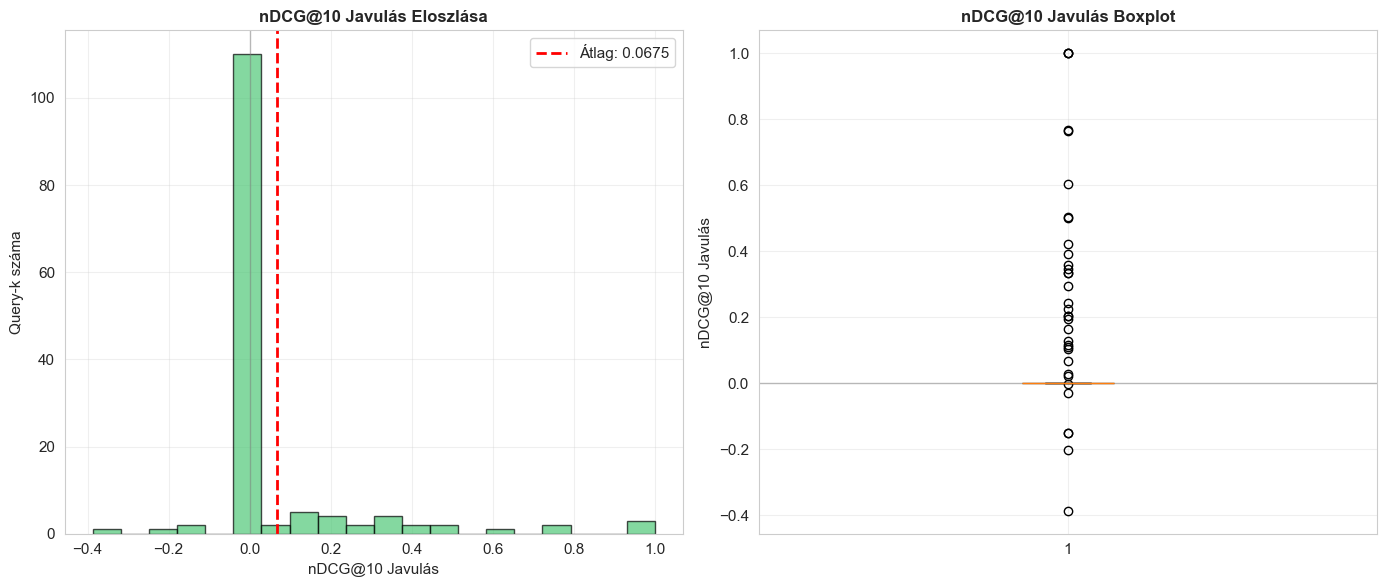


📊 Javulás Statisztikák (nDCG@10):
   Átlagos javulás: 0.0675
   Medián javulás: 0.0000
   Pozitív javulások: 28/141 (19.9%)
   Max javulás: 1.0000
   Min javulás: -0.3869


In [12]:
# Javulás eloszlása (improvement_ndcg@10)
if 'improvement_ndcg@10' in comparison_df.columns:
    improvements = comparison_df['improvement_ndcg@10'].dropna()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Hisztogram
    ax1.hist(improvements, bins=20, alpha=0.7, edgecolor='black', color='#50C878')
    ax1.axvline(improvements.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Átlag: {improvements.mean():.4f}')
    ax1.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax1.set_xlabel('nDCG@10 Javulás', fontsize=11)
    ax1.set_ylabel('Query-k száma', fontsize=11)
    ax1.set_title('nDCG@10 Javulás Eloszlása', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Boxplot
    ax2.boxplot(improvements, vert=True, patch_artist=True,
                boxprops=dict(facecolor='#50C878', alpha=0.7))
    ax2.axhline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax2.set_ylabel('nDCG@10 Javulás', fontsize=11)
    ax2.set_title('nDCG@10 Javulás Boxplot', fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statisztikák
    positive_improvements = (improvements > 0).sum()
    improvement_rate = (positive_improvements / len(improvements)) * 100
    
    print(f"\n📊 Javulás Statisztikák (nDCG@10):")
    print(f"   Átlagos javulás: {improvements.mean():.4f}")
    print(f"   Medián javulás: {improvements.median():.4f}")
    print(f"   Pozitív javulások: {positive_improvements}/{len(improvements)} ({improvement_rate:.1f}%)")
    print(f"   Max javulás: {improvements.max():.4f}")
    print(f"   Min javulás: {improvements.min():.4f}")
else:
    print("⚠️  'improvement_ndcg@10' oszlop nem található")


## 6. Összefoglalás

Ez a notebook a baseline hibrid retrieval és a GRPO tanított modell teljesítményét összehasonlítja **ugyanazon eval halmazon**.

A metrikák alapján látható:
- **Főbb javulások**: Mely metrikákon ért el a GRPO modell jelentős javulást
- **Query-szintű variáció**: Mennyire konzisztens a javulás query-k között
- **Statisztikai szignifikancia**: Az átlagos javulások és az eloszlás elemzése

**Következő lépések:**
- További metrikák finomhangolása
- Per-query deep dive analitika
- Hiperparaméter optimalizálás GRPO training-hez
